# Defensive Stock Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import zipfile
import time
from datetime import datetime

%matplotlib inline

In [2]:
# with zipfile.ZipFile("Data/archive.zip") as zip_ref:
#     zip_ref.extractall("Data")

In [3]:
df1 = pd.read_csv('Data/sp500_companies.csv')
df2 = pd.read_csv('Data/sp500_index.csv')
df3 = pd.read_csv('Data/sp500_stocks.csv')

#### Dataset #1

In [4]:
df1.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,149.70,2381442449408,1.305410e+11,0.081,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.067072
1,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software—Infrastructure,247.11,1855296897024,9.798300e+10,0.124,Redmond,WA,United States,221000.0,"Microsoft Corporation develops, licenses, and ...",0.052254
2,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,96.41,1249782136832,9.373300e+10,0.061,Mountain View,CA,United States,186779.0,Alphabet Inc. provides various products and pl...,0.035200
3,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,96.73,1249780563968,9.373300e+10,0.061,Mountain View,CA,United States,186779.0,Alphabet Inc. provides various products and pl...,0.035200
4,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,100.79,1028229365760,5.154900e+10,0.147,Seattle,WA,United States,1544000.0,"Amazon.com, Inc. engages in the retail sale of...",0.028960


In [5]:
df1 = df1[df1['Sector'] == 'Consumer Defensive']
df1.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
11,NYQ,WMT,Walmart Inc.,Walmart Inc.,Consumer Defensive,Discount Stores,142.58,395499831296,3.458600e+10,0.084,Bentonville,AR,United States,2300000.0,Walmart Inc. engages in the operation of retai...,0.011139
13,NYQ,PG,Procter & Gamble Company (The),The Procter & Gamble Company,Consumer Defensive,Household & Personal Products,140.97,341140373504,2.136400e+10,0.013,Cincinnati,OH,United States,106000.0,The Procter & Gamble Company provides branded ...,0.009608
20,NYQ,KO,Coca-Cola Company (The),The Coca-Cola Company,Consumer Defensive,Beverages—Non-Alcoholic,61.32,264866824192,1.341400e+10,0.102,Atlanta,GA,United States,79000.0,"The Coca-Cola Company, a beverage company, man...",0.007460
22,NMS,PEP,"Pepsico, Inc.","PepsiCo, Inc.",Consumer Defensive,Beverages—Non-Alcoholic,178.05,246180839424,1.515600e+10,0.088,Purchase,NY,United States,309000.0,"PepsiCo, Inc. manufactures, markets, distribut...",0.006934
23,NMS,COST,Costco Wholesale Corporation,Costco Wholesale Corporation,Consumer Defensive,Discount Stores,515.47,228575887360,9.693000e+09,0.150,Issaquah,WA,United States,304000.0,"Costco Wholesale Corporation, together with it...",0.006438


#### Dataset #2

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2519 non-null   object 
 1   S&P500  2519 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.5+ KB


In [7]:
df2.head()

,Date,S&P500
0,2012-11-12,1380.03
1,2012-11-13,1374.53
2,2012-11-14,1355.49
3,2012-11-15,1353.33
4,2012-11-16,1359.88


In [8]:
df2.shape

(2519, 2)

In [9]:
df2['Date'] = pd.to_datetime(df2['Date'],infer_datetime_format=True)

In [10]:
df2=df2[df2['Date'] > '2020-11-1']

In [11]:
df2 = df2.rename(columns={"S&P500":"Close"})

In [12]:
df2['Symbol'] = "S&P500"

In [13]:
df2.head()

,Date,Close,Symbol
2007,2020-11-02,3310.24,S&P500
2008,2020-11-03,3369.16,S&P500
2009,2020-11-04,3443.44,S&P500
2010,2020-11-05,3510.45,S&P500
2011,2020-11-06,3509.44,S&P500


In [14]:
df2.isna().count()

Date      512
Close     512
Symbol    512
dtype: int64

In [15]:
#### the dataset has no n/a values within the dataset, why is it showing n/a values? 

#### Dataset #3

In [16]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1629217 entries, 0 to 1629216
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Date       1629217 non-null  object 
 1   Symbol     1629217 non-null  object 
 2   Adj Close  1560290 non-null  float64
 3   Close      1560290 non-null  float64
 4   High       1560290 non-null  float64
 5   Low        1560290 non-null  float64
 6   Open       1560290 non-null  float64
 7   Volume     1560290 non-null  float64
dtypes: float64(6), object(2)
memory usage: 99.4+ MB


In [17]:
df3['Date'] = pd.to_datetime(df3['Date'])

In [18]:
df3 = df3.drop(['Adj Close', 'High', 'Low', 'Open', 'Volume'], axis=1)

In [19]:
df3.head()

,Date,Symbol,Close
0,2010-01-04,MMM,83.019997
1,2010-01-05,MMM,82.500000
2,2010-01-06,MMM,83.669998
3,2010-01-07,MMM,83.730003
4,2010-01-08,MMM,84.320000


In [20]:
df3 = df3.loc[df3['Symbol'].isin(['PEP', 'KO', 'PG', 'WMT', 'COST'])]

In [21]:
df3.isna().sum()

Date      0
Symbol    0
Close     0
dtype: int64

In [22]:
df3['Date'] = pd.to_datetime(df3['Date'],infer_datetime_format=True)

In [23]:
df3=df3[df3['Date'] > '2020-11-1']

In [24]:
df3.head()

,Date,Symbol,Close
384929,2020-11-02,KO,48.619999
384930,2020-11-03,KO,49.349998
384931,2020-11-04,KO,49.169998
384932,2020-11-05,KO,49.439999
384933,2020-11-06,KO,49.450001


#### Merge df2 and df3

In [25]:
# how would I plot df2 and df3
# the different values in Symbol?

In [26]:
df4 = pd.merge(df2,df3, on=['Date','Close', 'Symbol'], how='outer')

In [27]:
df4.head()

,Date,Close,Symbol
0,2020-11-02,3310.24,S&P500
1,2020-11-03,3369.16,S&P500
2,2020-11-04,3443.44,S&P500
3,2020-11-05,3510.45,S&P500
4,2020-11-06,3509.44,S&P500


In [37]:
symbol_groups = df4.groupby(by='Symbol')

<AxesSubplot:xlabel='Date'>

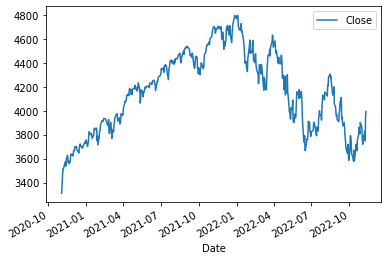

In [51]:
symbol_groups.get_group('S&P500').plot('Date','Close')

<AxesSubplot:xlabel='Date'>

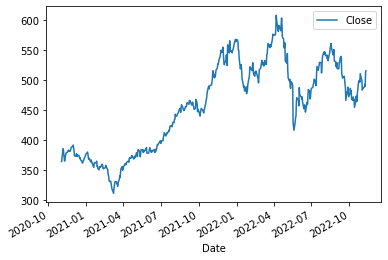

In [50]:
symbol_groups.get_group('COST').plot('Date','Close')

<AxesSubplot:xlabel='Date'>

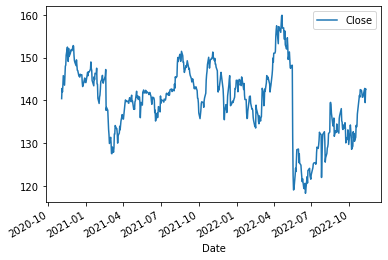

In [52]:
symbol_groups.get_group('WMT').plot('Date','Close')

<AxesSubplot:xlabel='Date'>

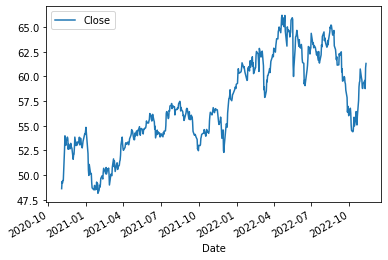

In [53]:
symbol_groups.get_group('KO').plot('Date','Close')

<AxesSubplot:xlabel='Date'>

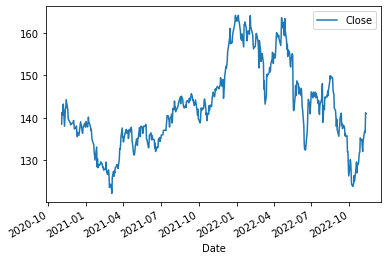

In [54]:
symbol_groups.get_group('PG').plot('Date','Close')

<AxesSubplot:xlabel='Date'>

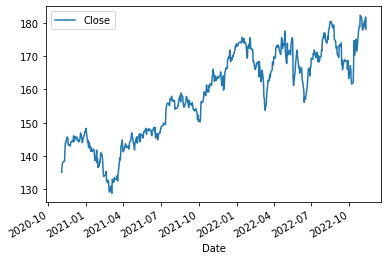

In [55]:
symbol_groups.get_group('PEP').plot('Date','Close')

In [ ]:
# for close, symbol in year_groups:
#     df4[]



# temp_annual = pd.DataFrame()

# for yr, group in year_groups:
#     temp_annual[yr.year] = group.values.ravel()

# # Plot the yearly groups as subplots
# temp_annual.plot(figsize = (22,15), subplots=True, legend=True)
# plt.show()